In [1]:
import joblib

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import os

# text feature extraction
from helper import TextFeatures, CoreNLPHelper
import importlib
coreNLPfeatures = CoreNLPHelper.CoreNLPFeatures(core_nlp_server_url="http://localhost:9000")

In [2]:
import_obj = joblib.load('svm_style_classifier_v5_trigram.joblib.z')
svm_clf = import_obj['model']
svm_clf_df = import_obj['df_train']
svm_clf_cols_excluded = import_obj['excluded']
svm_clf_trigram_vectorizer = import_obj['trigram_vectorizer']

# Load your data

In [3]:
PATH_TO_CSV = os.path.join("final_eval_datasets", "evaluation_sample3000_GPT_M2.csv")
INPUT_COLUMN_SENTENCES = ["sent", "sent_output"]
OUTPUT_COLUMN_SVM_PREDICTION_SUFFIX = "style_svm"

In [4]:
df = pd.read_csv(PATH_TO_CSV)

# checks
for col in INPUT_COLUMN_SENTENCES:
    if not col in df.columns:
        raise ValueError(f"Please check the '{INPUT_COLUMN_SENTENCES}' input column")
if OUTPUT_COLUMN_SVM_PREDICTION_SUFFIX in df.columns:
    raise ValueError("Please choose different name for svm output column")
    
df.head()

,Unnamed: 0,Unnamed: 0.1,sent,true_label,pred_label,prob0,prob1,prob_max,len,sent_masked,source,sent_output
0,0,102226,"therefore, for languages like chinese and japa...",1,0,0.670159,0.416702,0.670159,29,"therefore, for <unk> like chinese and japanese...",cs_conf,"therefore, tokenization is a matter of languag..."
1,1,28200,"similar to these subtopics, feature representa...",1,0,0.776326,0.337896,0.776326,40,"similar to these subtopics, <unk> <unk> is put...",cs_conf,as an essential element for the three main com...
2,2,75338,these clusters are ranked by collection select...,1,0,0.590534,0.567582,0.590534,14,these <unk> are ranked by <unk> <unk> to deter...,cs_conf,in order to determine which clusters to search...
3,3,100804,"however, the behavior network is realized by r...",1,0,0.732323,0.412871,0.732323,38,"however, the <unk> <unk> is realized by runnin...",cs_conf,"however, the behavior network is designed to r..."
4,4,54387,"how well the code is performing, the percentag...",1,0,0.692315,0.452050,0.692315,23,"how well the <unk> is performing, the percenta...",cs_conf,"how well the code is working, how much work is..."


# Prediction

In [5]:
def add_features(df, trigram_vectorizer=None):
    columns = {}

    print("lexical features character based")
    (cols_lexical_char, df_sub) = TextFeatures.extract_lexical_features_character_based(df["sentence"])
    df[cols_lexical_char] = df_sub[cols_lexical_char]
    columns["cols_lexical_char"] = cols_lexical_char

    print("lexical features word based")
    (cols_lexical_word, df_sub) = TextFeatures.extract_lexical_features_word_based(df["sentence"])
    df[cols_lexical_word] = df_sub[cols_lexical_word]
    columns["cols_lexical_word"] = cols_lexical_word
    
    print("lexical features vocabulary richness")
    (cols_vocab_rich, df_sub) = TextFeatures.extract_vocabulary_richness(df["sentence"])
    df[cols_vocab_rich] = df_sub[cols_vocab_rich]
    columns["cols_vocab_rich"] = cols_vocab_rich

    print("pos tags")
    (cols_pos_tag, df_sub) = TextFeatures.extract_pos_tags(df["sentence"], universal=False)
    df[cols_pos_tag] = df_sub[cols_pos_tag]
    columns["cols_pos_tag"] = cols_pos_tag

    print("passive sentence")
    (cols_passive, df_sub) = coreNLPfeatures.extract_passive_case(df["sentence"])
    df[cols_passive] = df_sub[cols_passive]
    columns["cols_passive"] = cols_passive
    
    print("char trigrams")
    (cols_trigram, df_sub, vec) = TextFeatures.extract_char_trigrams(df["sentence"], trigram_vectorizer)
    df[cols_trigram] = df_sub[cols_trigram]
    columns["char_trigrams"] = cols_trigram
    
    return (df, columns, vec)


def svm_predict(df, column):
    
    # making sure to leave original dataset as it is
    df_features = df[[column]].copy()
    df_features.rename({column: "sentence"}, axis=1, inplace = True)

    # apply feature extraction
    (df_features, cols_features, vec) = add_features(df_features, svm_clf_trigram_vectorizer)

    sci_pred = svm_clf.predict(df_features.drop(svm_clf_cols_excluded, axis=1, errors = "ignore"))
    df["_".join([column,OUTPUT_COLUMN_SVM_PREDICTION_SUFFIX])] = sci_pred

    del df_features
    
    return df

In [6]:
for col in INPUT_COLUMN_SENTENCES:
    print(f"### Predicting for column: {col}")
    df = svm_predict(df, col)

### Predicting for column: sent
lexical features character based
lexical features word based


  0%|          | 0/3000 [00:00<?, ?it/s]

lexical features vocabulary richness
pos tags


  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

passive sentence


  0%|          | 0/3000 [00:00<?, ?it/s]

char trigrams


  0%|          | 0/3000 [00:00<?, ?it/s]

### Predicting for column: sent_output
lexical features character based
lexical features word based


  0%|          | 0/3000 [00:00<?, ?it/s]

lexical features vocabulary richness
pos tags


  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

passive sentence


  0%|          | 0/3000 [00:00<?, ?it/s]

char trigrams


  0%|          | 0/3000 [00:00<?, ?it/s]

## Predict scientificity

### Graph for column sent


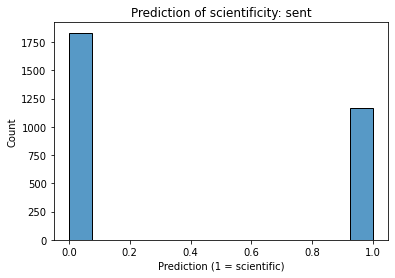

### Graph for column sent_output


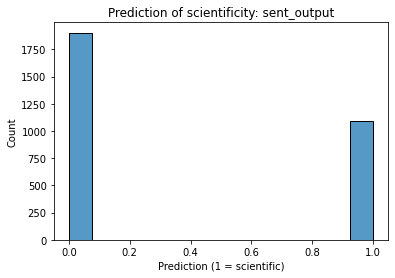

In [7]:
for col in INPUT_COLUMN_SENTENCES:
    print(f"### Graph for column {col}")
    ax = sns.histplot(data=df, x="_".join([col,OUTPUT_COLUMN_SVM_PREDICTION_SUFFIX]))
    ax.set_title(f"Prediction of scientificity: {col}")
    ax.set_xlabel("Prediction (1 = scientific)")
    plt.show()

# Export

In [8]:
df.to_csv(PATH_TO_CSV+"_svm.csv", index=False)